# 測試

In [1]:
#載入測試用資料
import pandas as pd
import numpy as np
data = pd.read_csv('../data/Automobile_Test.csv')
data.head()

,symboling,Normalized-losses,make,Fuel-type,aspiration,Num-of-doors,Body-style,Drive-wheels,Engine-location,Wheel-base,...,Engine-size,Fuel-system,bore,stroke,Compression-ratio,horsepower,Peak-rpm,City-mpg,Highway-mpg,price
0,1,118.0,dodge,gas,std,two,hatchback,fwd,front,93.7,...,90,2bbl,2.97,3.23,9.41,68.0,5500.0,37,41,5572.0
1,0,NaN,jaguar,gas,std,two,sedan,rwd,front,102.0,...,326,mpfi,3.54,2.76,11.50,262.0,5000.0,13,17,36000.0
2,0,NaN,isuzu,gas,std,four,sedan,rwd,front,94.3,...,111,2bbl,3.31,3.23,8.50,78.0,4800.0,24,29,6785.0
3,-1,65.0,toyota,gas,std,four,hatchback,fwd,front,102.4,...,122,mpfi,3.31,3.54,8.70,92.0,4200.0,27,32,11248.0
4,2,104.0,saab,gas,turbo,four,sedan,fwd,front,99.1,...,121,mpfi,3.54,3.07,9.00,160.0,5500.0,19,26,18620.0


In [2]:
# 刪除 price為空值的資料列
data = data.dropna(subset=['price'])

In [3]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):         
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []
        
    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names       
        
        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                # self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數
            
            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()    
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()    
                    self.scaler[fname].fit(data[[fname]])

            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)                    
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)
                
        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()
        
        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])
            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:                   
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass                
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)          

In [4]:
# 載入前處理模型並轉換資料
ap = AutoPreprocess.load("C:/DATA/preprocess.bin")
X = ap.transform(data)
y = data['price']

In [7]:
# 載入模型
f =  open("C:/DATA/model.bin", "rb")
model =  pickle.load(f) 
model

RandomForestRegressor()

測試組 R2: 0.9145928466339514


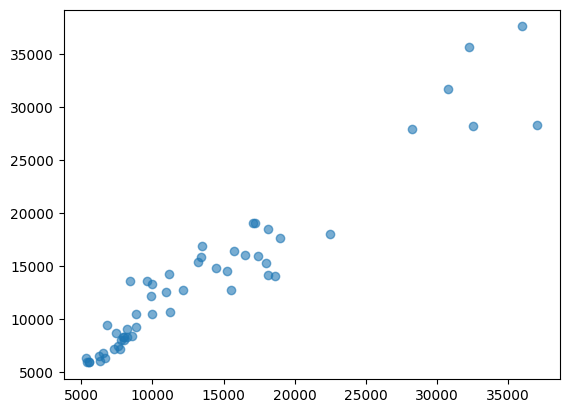

In [8]:
# 驗證模型
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print("測試組 R2:", r2)
plt.scatter(y, y_pred, alpha=0.6)
plt.show()

# 推理

In [9]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):         
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []
        
    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names       
        
        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                # self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數
            
            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()    
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()    
                    self.scaler[fname].fit(data[[fname]])

            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)                    
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)
                
        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()
        
        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])
            
            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:                   
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass                
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)          

In [14]:
data_dcit = {
    "symboling" : 0,
    "make" : "jaguar",
    "horsepower" : 68.0,
    "Engine-size" : 326
}

In [15]:
# 載入前處理模型並轉換資料
ap = AutoPreprocess.load("C:/DATA/preprocess.bin")
X = ap.transform(data_dcit)

In [16]:
# 載入模型
f =  open("C:/DATA/model.bin", "rb")
model =  pickle.load(f) 
model

RandomForestRegressor()

In [17]:
y_pred = model.predict(X)
y_pred

array([25481.99833333])